<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [GTSRB4] - Data augmentation 
<!-- DESC --> Episode 4 : Adding data by data augmentation when we lack it, to improve our results
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
  - Trying to improve training by **enhancing the data**
  - Using Keras' **data augmentation utilities**, finding their limits...
  
The German Traffic Sign Recognition Benchmark (GTSRB) is a dataset with more than 50,000 photos of road signs from about 40 classes.  
The final aim is to recognise them !  

Description is available there : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset


## What we're going to do :
 - Increase and improve the training dataset
 - Identify the limits of these tools

## Step 1 - Import and init
### 1.1 - Python stuffs

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import h5py

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import os, sys, time, random

from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/GTSRB4.001'
datasets_dir = pwk.init('GTSRB4', run_dir)

**\*\* Overrided parameters : \*\***

run_dir              : ./run/GTSRB4_done


<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.17
Notebook id          : GTSRB4
Run time             : Monday 01 March 2021, 18:50:00
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run/GTSRB4_done
Update keras cache   : False
Save figs            : True
Path figs            : ./run/GTSRB4_done/figs


### 1.2 - Parameters
`scale` is the proportion of the dataset that will be used during the training. (1 mean 100%)  

In [2]:
enhanced_dir = './data'
# enhanced_dir = f'{datasets_dir}/GTSRB/enhanced'

dataset_name = 'set-24x24-L'
batch_size   = 64
epochs       = 20
scale        = 1



Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('enhanced_dir', 'dataset_name', 'batch_size', 'epochs', 'scale')

**\*\* Overrided parameters : \*\***

enhanced_dir         : /gpfswork/rech/mlh/uja62cb/datasets/GTSRB/enhanced
dataset_name         : set-24x24-L
batch_size           : 64
epochs               : 5
scale                : 1


## Step 2 - Load dataset
Dataset is one of the saved dataset: RGB25, RGB35, L25, L35, etc.  
First of all, we're going to use a smart dataset : **set-24x24-L**  
(with a GPU, it only takes 35'' compared to more than 5' with a CPU !)

In [4]:
def read_dataset(enhanced_dir, dataset_name):
    '''Reads h5 dataset
    Args:
        filename     : datasets filename
        dataset_name : dataset name, without .h5
    Returns:    x_train,y_train, x_test,y_test data, x_meta,y_meta'''
    # ---- Read dataset
    pwk.chrono_start()
    filename = f'{enhanced_dir}/{dataset_name}.h5'
    with  h5py.File(filename,'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test  = f['x_test'][:]
        y_test  = f['y_test'][:]
        x_meta  = f['x_meta'][:]
        y_meta  = f['y_meta'][:]
    print(x_train.shape, y_train.shape)
    # ---- Shuffle
    x_train,y_train=pwk.shuffle_np_dataset(x_train,y_train)

    # ---- done
    duration = pwk.chrono_stop(hdelay=True)
    size     = pwk.hsize(os.path.getsize(filename))
    print(f'Dataset "{dataset_name}" is loaded and shuffled. ({size} in {duration})')
    return x_train,y_train, x_test,y_test, x_meta,y_meta

# ---- Read dataset
#
x_train,y_train,x_test,y_test, x_meta,y_meta = read_dataset(enhanced_dir, dataset_name)

# ---- Rescale 
#
x_train,y_train, x_test,y_test = pwk.rescale_dataset(x_train,y_train,x_test,y_test, scale=scale)

(39209, 24, 24, 1) (39209,)


Dataset "set-24x24-L" is loaded and shuffled. (228.8 Mo in 00:00:00 487ms)


## Step 3 - Models
We will now build a model and train it...

This is my model ;-) 

In [5]:
# A basic model
#
def get_model_v1(lx,ly,lz):
    
    model = keras.models.Sequential()
    
    model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1500, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model

## Step 4 - Callbacks  
We prepare 2 kind callbacks :  TensorBoard and Model backup

In [6]:
pwk.mkdir(run_dir + '/models')
pwk.mkdir(run_dir + '/logs')

# ---- Callback tensorboard
log_dir = run_dir + "/logs/tb_" + pwk.tag_now()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# ---- Callback ModelCheckpoint - Save best model
save_dir = run_dir + "/models/best-model.h5"
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='accuracy', save_best_only=True)

# ---- Callback ModelCheckpoint - Save model each epochs
save_dir = run_dir + "/models/model-{epoch:04d}.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0)

path=os.path.abspath(f'{run_dir}/logs')
print(f'To run tensorboard :\ntensorboard --logdir {path}')

To run tensorboard :
tensorboard --logdir /gpfsdswork/projects/rech/mlh/uja62cb/fidle/GTSRB/run/GTSRB4_done/logs


## Step 5 - Data generator

In [7]:
datagen = keras.preprocessing.image.ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.)
datagen.fit(x_train)

## Step 6 - Train the model
**Get my data shape :**

In [8]:
(n,lx,ly,lz) = x_train.shape
print("Images of the dataset have this folowing shape : ",(lx,ly,lz))

Images of the dataset have this folowing shape :  (24, 24, 1)


**Get and compile a model, with the data shape :**

In [9]:
model = get_model_v1(lx,ly,lz)

# model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**Train it :** 

In [10]:
pwk.chrono_start()

history = model.fit(  datagen.flow(x_train, y_train, batch_size=batch_size),
                      steps_per_epoch = int(x_train.shape[0]/batch_size),
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_test, y_test),
                      callbacks=[tensorboard_callback, bestmodel_callback, savemodel_callback] )

model.save(f'{run_dir}/models/last-model.h5')

pwk.chrono_show()

Epoch 1/5


  1/612 [..............................] - ETA: 31:43 - loss: 3.7523 - accuracy: 0.0156

  3/612 [..............................] - ETA: 34s - loss: 3.7342 - accuracy: 0.0243  

  7/612 [..............................] - ETA: 17s - loss: 3.7090 - accuracy: 0.0304

 11/612 [..............................] - ETA: 13s - loss: 3.6837 - accuracy: 0.0354

 15/612 [..............................] - ETA: 12s - loss: 3.6656 - accuracy: 0.0395

 19/612 [..............................] - ETA: 11s - loss: 3.6512 - accuracy: 0.0428

 23/612 [>.............................] - ETA: 10s - loss: 3.6404 - accuracy: 0.0454

 27/612 [>.............................] - ETA: 10s - loss: 3.6305 - accuracy: 0.0475

 31/612 [>.............................] - ETA: 10s - loss: 3.6231 - accuracy: 0.0491

 35/612 [>.............................] - ETA: 9s - loss: 3.6158 - accuracy: 0.0501 

 39/612 [>.............................] - ETA: 9s - loss: 3.6096 - accuracy: 0.0509

 43/612 [=>............................] - ETA: 9s - loss: 3.6042 - accuracy: 0.0518

 47/612 [=>............................] - ETA: 9s - loss: 3.5989 - accuracy: 0.0527

 51/612 [=>............................] - ETA: 9s - loss: 3.5940 - accuracy: 0.0536

 55/612 [=>............................] - ETA: 9s - loss: 3.5889 - accuracy: 0.0546

 59/612 [=>............................] - ETA: 8s - loss: 3.5839 - accuracy: 0.0556

 63/612 [==>...........................] - ETA: 8s - loss: 3.5791 - accuracy: 0.0566

 67/612 [==>...........................] - ETA: 8s - loss: 3.5744 - accuracy: 0.0576

 71/612 [==>...........................] - ETA: 8s - loss: 3.5699 - accuracy: 0.0584

 75/612 [==>...........................] - ETA: 8s - loss: 3.5654 - accuracy: 0.0592

 79/612 [==>...........................] - ETA: 8s - loss: 3.5609 - accuracy: 0.0600

 83/612 [===>..........................] - ETA: 8s - loss: 3.5567 - accuracy: 0.0608

 87/612 [===>..........................] - ETA: 8s - loss: 3.5525 - accuracy: 0.0617

 91/612 [===>..........................] - ETA: 8s - loss: 3.5484 - accuracy: 0.0625

 95/612 [===>..........................] - ETA: 8s - loss: 3.5443 - accuracy: 0.0634

 99/612 [===>..........................] - ETA: 8s - loss: 3.5405 - accuracy: 0.0642

103/612 [====>.........................] - ETA: 7s - loss: 3.5367 - accuracy: 0.0649

107/612 [====>.........................] - ETA: 7s - loss: 3.5330 - accuracy: 0.0657

111/612 [====>.........................] - ETA: 7s - loss: 3.5294 - accuracy: 0.0665

115/612 [====>.........................] - ETA: 7s - loss: 3.5258 - accuracy: 0.0673

119/612 [====>.........................] - ETA: 7s - loss: 3.5223 - accuracy: 0.0681

123/612 [=====>........................] - ETA: 7s - loss: 3.5189 - accuracy: 0.0689

127/612 [=====>........................] - ETA: 7s - loss: 3.5154 - accuracy: 0.0698

131/612 [=====>........................] - ETA: 7s - loss: 3.5119 - accuracy: 0.0707

135/612 [=====>........................] - ETA: 7s - loss: 3.5082 - accuracy: 0.0716

139/612 [=====>........................] - ETA: 7s - loss: 3.5044 - accuracy: 0.0726

143/612 [======>.......................] - ETA: 7s - loss: 3.5006 - accuracy: 0.0736

147/612 [======>.......................] - ETA: 7s - loss: 3.4966 - accuracy: 0.0746

151/612 [======>.......................] - ETA: 7s - loss: 3.4925 - accuracy: 0.0756

155/612 [======>.......................] - ETA: 7s - loss: 3.4883 - accuracy: 0.0767

159/612 [======>.......................] - ETA: 6s - loss: 3.4841 - accuracy: 0.0778

163/612 [======>.......................] - ETA: 6s - loss: 3.4797 - accuracy: 0.0789

167/612 [=======>......................] - ETA: 6s - loss: 3.4753 - accuracy: 0.0800

171/612 [=======>......................] - ETA: 6s - loss: 3.4707 - accuracy: 0.0812

175/612 [=======>......................] - ETA: 6s - loss: 3.4661 - accuracy: 0.0824

179/612 [=======>......................] - ETA: 6s - loss: 3.4613 - accuracy: 0.0835

183/612 [=======>......................] - ETA: 6s - loss: 3.4565 - accuracy: 0.0847

187/612 [========>.....................] - ETA: 6s - loss: 3.4517 - accuracy: 0.0860

191/612 [========>.....................] - ETA: 6s - loss: 3.4468 - accuracy: 0.0872

195/612 [========>.....................] - ETA: 6s - loss: 3.4418 - accuracy: 0.0884

199/612 [========>.....................] - ETA: 6s - loss: 3.4367 - accuracy: 0.0897

203/612 [========>.....................] - ETA: 6s - loss: 3.4316 - accuracy: 0.0909

207/612 [=========>....................] - ETA: 6s - loss: 3.4263 - accuracy: 0.0922

211/612 [=========>....................] - ETA: 6s - loss: 3.4210 - accuracy: 0.0935

215/612 [=========>....................] - ETA: 6s - loss: 3.4157 - accuracy: 0.0948

219/612 [=========>....................] - ETA: 5s - loss: 3.4102 - accuracy: 0.0961

223/612 [=========>....................] - ETA: 5s - loss: 3.4047 - accuracy: 0.0975

227/612 [==========>...................] - ETA: 5s - loss: 3.3991 - accuracy: 0.0988

231/612 [==========>...................] - ETA: 5s - loss: 3.3935 - accuracy: 0.1002

235/612 [==========>...................] - ETA: 5s - loss: 3.3878 - accuracy: 0.1015

239/612 [==========>...................] - ETA: 5s - loss: 3.3820 - accuracy: 0.1029

243/612 [==========>...................] - ETA: 5s - loss: 3.3761 - accuracy: 0.1043

247/612 [===========>..................] - ETA: 5s - loss: 3.3702 - accuracy: 0.1057

251/612 [===========>..................] - ETA: 5s - loss: 3.3642 - accuracy: 0.1071

255/612 [===========>..................] - ETA: 5s - loss: 3.3582 - accuracy: 0.1086

259/612 [===========>..................] - ETA: 5s - loss: 3.3521 - accuracy: 0.1100

263/612 [===========>..................] - ETA: 5s - loss: 3.3460 - accuracy: 0.1115

267/612 [============>.................] - ETA: 5s - loss: 3.3398 - accuracy: 0.1129

271/612 [============>.................] - ETA: 5s - loss: 3.3336 - accuracy: 0.1144

275/612 [============>.................] - ETA: 5s - loss: 3.3274 - accuracy: 0.1158

279/612 [============>.................] - ETA: 5s - loss: 3.3212 - accuracy: 0.1173

283/612 [============>.................] - ETA: 4s - loss: 3.3150 - accuracy: 0.1187

287/612 [=============>................] - ETA: 4s - loss: 3.3088 - accuracy: 0.1202

291/612 [=============>................] - ETA: 4s - loss: 3.3026 - accuracy: 0.1217

295/612 [=============>................] - ETA: 4s - loss: 3.2963 - accuracy: 0.1231

299/612 [=============>................] - ETA: 4s - loss: 3.2901 - accuracy: 0.1246

303/612 [=============>................] - ETA: 4s - loss: 3.2838 - accuracy: 0.1261

307/612 [==============>...............] - ETA: 4s - loss: 3.2775 - accuracy: 0.1275

311/612 [==============>...............] - ETA: 4s - loss: 3.2712 - accuracy: 0.1290

315/612 [==============>...............] - ETA: 4s - loss: 3.2649 - accuracy: 0.1305

319/612 [==============>...............] - ETA: 4s - loss: 3.2587 - accuracy: 0.1319

323/612 [==============>...............] - ETA: 4s - loss: 3.2524 - accuracy: 0.1334

327/612 [===============>..............] - ETA: 4s - loss: 3.2461 - accuracy: 0.1349

331/612 [===============>..............] - ETA: 4s - loss: 3.2398 - accuracy: 0.1364

335/612 [===============>..............] - ETA: 4s - loss: 3.2335 - accuracy: 0.1378

339/612 [===============>..............] - ETA: 4s - loss: 3.2272 - accuracy: 0.1393

343/612 [===============>..............] - ETA: 4s - loss: 3.2210 - accuracy: 0.1408

347/612 [================>.............] - ETA: 3s - loss: 3.2147 - accuracy: 0.1422

351/612 [================>.............] - ETA: 3s - loss: 3.2085 - accuracy: 0.1437

355/612 [================>.............] - ETA: 3s - loss: 3.2023 - accuracy: 0.1451

359/612 [================>.............] - ETA: 3s - loss: 3.1961 - accuracy: 0.1466

363/612 [================>.............] - ETA: 3s - loss: 3.1900 - accuracy: 0.1480

367/612 [================>.............] - ETA: 3s - loss: 3.1838 - accuracy: 0.1495

371/612 [=================>............] - ETA: 3s - loss: 3.1777 - accuracy: 0.1509

375/612 [=================>............] - ETA: 3s - loss: 3.1715 - accuracy: 0.1523

379/612 [=================>............] - ETA: 3s - loss: 3.1654 - accuracy: 0.1538

383/612 [=================>............] - ETA: 3s - loss: 3.1593 - accuracy: 0.1552

387/612 [=================>............] - ETA: 3s - loss: 3.1532 - accuracy: 0.1567

391/612 [==================>...........] - ETA: 3s - loss: 3.1471 - accuracy: 0.1581

395/612 [==================>...........] - ETA: 3s - loss: 3.1411 - accuracy: 0.1595

399/612 [==================>...........] - ETA: 3s - loss: 3.1350 - accuracy: 0.1610

403/612 [==================>...........] - ETA: 3s - loss: 3.1290 - accuracy: 0.1624

407/612 [==================>...........] - ETA: 3s - loss: 3.1229 - accuracy: 0.1638

411/612 [===================>..........] - ETA: 3s - loss: 3.1169 - accuracy: 0.1653

415/612 [===================>..........] - ETA: 2s - loss: 3.1109 - accuracy: 0.1667

417/612 [===================>..........] - ETA: 2s - loss: 3.1080 - accuracy: 0.1674

422/612 [===================>..........] - ETA: 2s - loss: 3.1005 - accuracy: 0.1692

426/612 [===================>..........] - ETA: 2s - loss: 3.0946 - accuracy: 0.1706

430/612 [====================>.........] - ETA: 2s - loss: 3.0887 - accuracy: 0.1720

434/612 [====================>.........] - ETA: 2s - loss: 3.0828 - accuracy: 0.1734

438/612 [====================>.........] - ETA: 2s - loss: 3.0769 - accuracy: 0.1748

442/612 [====================>.........] - ETA: 2s - loss: 3.0711 - accuracy: 0.1762

446/612 [====================>.........] - ETA: 2s - loss: 3.0653 - accuracy: 0.1775

450/612 [=====================>........] - ETA: 2s - loss: 3.0595 - accuracy: 0.1789

454/612 [=====================>........] - ETA: 2s - loss: 3.0538 - accuracy: 0.1803

458/612 [=====================>........] - ETA: 2s - loss: 3.0480 - accuracy: 0.1816

462/612 [=====================>........] - ETA: 2s - loss: 3.0423 - accuracy: 0.1830

466/612 [=====================>........] - ETA: 2s - loss: 3.0366 - accuracy: 0.1843

470/612 [======================>.......] - ETA: 2s - loss: 3.0310 - accuracy: 0.1857

474/612 [======================>.......] - ETA: 2s - loss: 3.0253 - accuracy: 0.1870

478/612 [======================>.......] - ETA: 2s - loss: 3.0197 - accuracy: 0.1883

482/612 [======================>.......] - ETA: 1s - loss: 3.0141 - accuracy: 0.1897

486/612 [======================>.......] - ETA: 1s - loss: 3.0085 - accuracy: 0.1910

490/612 [=======================>......] - ETA: 1s - loss: 3.0030 - accuracy: 0.1923

494/612 [=======================>......] - ETA: 1s - loss: 2.9975 - accuracy: 0.1936

498/612 [=======================>......] - ETA: 1s - loss: 2.9920 - accuracy: 0.1949

502/612 [=======================>......] - ETA: 1s - loss: 2.9865 - accuracy: 0.1962

506/612 [=======================>......] - ETA: 1s - loss: 2.9811 - accuracy: 0.1975

510/612 [========================>.....] - ETA: 1s - loss: 2.9756 - accuracy: 0.1988

514/612 [========================>.....] - ETA: 1s - loss: 2.9702 - accuracy: 0.2001

518/612 [========================>.....] - ETA: 1s - loss: 2.9648 - accuracy: 0.2014

522/612 [========================>.....] - ETA: 1s - loss: 2.9595 - accuracy: 0.2027

526/612 [========================>.....] - ETA: 1s - loss: 2.9541 - accuracy: 0.2039

530/612 [========================>.....] - ETA: 1s - loss: 2.9488 - accuracy: 0.2052

534/612 [=========================>....] - ETA: 1s - loss: 2.9435 - accuracy: 0.2064

538/612 [=========================>....] - ETA: 1s - loss: 2.9383 - accuracy: 0.2077

542/612 [=========================>....] - ETA: 1s - loss: 2.9331 - accuracy: 0.2089

546/612 [=========================>....] - ETA: 0s - loss: 2.9278 - accuracy: 0.2102

550/612 [=========================>....] - ETA: 0s - loss: 2.9227 - accuracy: 0.2114

554/612 [==========================>...] - ETA: 0s - loss: 2.9175 - accuracy: 0.2127

558/612 [==========================>...] - ETA: 0s - loss: 2.9123 - accuracy: 0.2139

562/612 [==========================>...] - ETA: 0s - loss: 2.9072 - accuracy: 0.2151

566/612 [==========================>...] - ETA: 0s - loss: 2.9021 - accuracy: 0.2163

570/612 [==========================>...] - ETA: 0s - loss: 2.8971 - accuracy: 0.2175

574/612 [===========================>..] - ETA: 0s - loss: 2.8920 - accuracy: 0.2188

578/612 [===========================>..] - ETA: 0s - loss: 2.8870 - accuracy: 0.2200

582/612 [===========================>..] - ETA: 0s - loss: 2.8820 - accuracy: 0.2211

586/612 [===========================>..] - ETA: 0s - loss: 2.8771 - accuracy: 0.2223

590/612 [===========================>..] - ETA: 0s - loss: 2.8721 - accuracy: 0.2235

594/612 [============================>.] - ETA: 0s - loss: 2.8672 - accuracy: 0.2247

598/612 [============================>.] - ETA: 0s - loss: 2.8623 - accuracy: 0.2259

602/612 [============================>.] - ETA: 0s - loss: 2.8574 - accuracy: 0.2271

606/612 [============================>.] - ETA: 0s - loss: 2.8525 - accuracy: 0.2282

610/612 [============================>.] - ETA: 0s - loss: 2.8477 - accuracy: 0.2294

612/612 [==============================] - 14s 17ms/step - loss: 2.8441 - accuracy: 0.2302 - val_loss: 0.7962 - val_accuracy: 0.7733


Epoch 2/5
  1/612 [..............................] - ETA: 26s - loss: 1.4981 - accuracy: 0.5625

  5/612 [..............................] - ETA: 9s - loss: 1.2146 - accuracy: 0.6489 

  9/612 [..............................] - ETA: 9s - loss: 1.1748 - accuracy: 0.6569

 13/612 [..............................] - ETA: 9s - loss: 1.1613 - accuracy: 0.6608

 17/612 [..............................] - ETA: 8s - loss: 1.1471 - accuracy: 0.6649

 21/612 [>.............................] - ETA: 8s - loss: 1.1384 - accuracy: 0.6663

 25/612 [>.............................] - ETA: 8s - loss: 1.1324 - accuracy: 0.6669

 29/612 [>.............................] - ETA: 8s - loss: 1.1297 - accuracy: 0.6675

 33/612 [>.............................] - ETA: 8s - loss: 1.1272 - accuracy: 0.6674

 37/612 [>.............................] - ETA: 8s - loss: 1.1257 - accuracy: 0.6669

 41/612 [=>............................] - ETA: 8s - loss: 1.1242 - accuracy: 0.6665

 45/612 [=>............................] - ETA: 8s - loss: 1.1223 - accuracy: 0.6665

 49/612 [=>............................] - ETA: 8s - loss: 1.1210 - accuracy: 0.6663

 53/612 [=>............................] - ETA: 8s - loss: 1.1197 - accuracy: 0.6661

 57/612 [=>............................] - ETA: 8s - loss: 1.1184 - accuracy: 0.6661

 61/612 [=>............................] - ETA: 8s - loss: 1.1170 - accuracy: 0.6662

 65/612 [==>...........................] - ETA: 8s - loss: 1.1154 - accuracy: 0.6663

 69/612 [==>...........................] - ETA: 8s - loss: 1.1135 - accuracy: 0.6665

 73/612 [==>...........................] - ETA: 8s - loss: 1.1116 - accuracy: 0.6668

 77/612 [==>...........................] - ETA: 8s - loss: 1.1100 - accuracy: 0.6670

 81/612 [==>...........................] - ETA: 7s - loss: 1.1085 - accuracy: 0.6673

 85/612 [===>..........................] - ETA: 7s - loss: 1.1070 - accuracy: 0.6675

 89/612 [===>..........................] - ETA: 7s - loss: 1.1054 - accuracy: 0.6678

 93/612 [===>..........................] - ETA: 7s - loss: 1.1037 - accuracy: 0.6682

 97/612 [===>..........................] - ETA: 7s - loss: 1.1021 - accuracy: 0.6686

101/612 [===>..........................] - ETA: 7s - loss: 1.1006 - accuracy: 0.6689

105/612 [====>.........................] - ETA: 7s - loss: 1.0992 - accuracy: 0.6693

109/612 [====>.........................] - ETA: 7s - loss: 1.0979 - accuracy: 0.6696

113/612 [====>.........................] - ETA: 7s - loss: 1.0966 - accuracy: 0.6700

117/612 [====>.........................] - ETA: 7s - loss: 1.0954 - accuracy: 0.6703

121/612 [====>.........................] - ETA: 7s - loss: 1.0942 - accuracy: 0.6706

125/612 [=====>........................] - ETA: 7s - loss: 1.0931 - accuracy: 0.6709

129/612 [=====>........................] - ETA: 7s - loss: 1.0919 - accuracy: 0.6713

133/612 [=====>........................] - ETA: 7s - loss: 1.0909 - accuracy: 0.6715

137/612 [=====>........................] - ETA: 7s - loss: 1.0900 - accuracy: 0.6718

141/612 [=====>........................] - ETA: 7s - loss: 1.0891 - accuracy: 0.6720

145/612 [======>.......................] - ETA: 7s - loss: 1.0881 - accuracy: 0.6723

149/612 [======>.......................] - ETA: 6s - loss: 1.0871 - accuracy: 0.6725

153/612 [======>.......................] - ETA: 6s - loss: 1.0860 - accuracy: 0.6727

157/612 [======>.......................] - ETA: 6s - loss: 1.0849 - accuracy: 0.6730

161/612 [======>.......................] - ETA: 6s - loss: 1.0838 - accuracy: 0.6732

165/612 [=======>......................] - ETA: 6s - loss: 1.0826 - accuracy: 0.6735

169/612 [=======>......................] - ETA: 6s - loss: 1.0815 - accuracy: 0.6738

173/612 [=======>......................] - ETA: 6s - loss: 1.0804 - accuracy: 0.6741

177/612 [=======>......................] - ETA: 6s - loss: 1.0793 - accuracy: 0.6743

181/612 [=======>......................] - ETA: 6s - loss: 1.0783 - accuracy: 0.6745

185/612 [========>.....................] - ETA: 6s - loss: 1.0772 - accuracy: 0.6748

189/612 [========>.....................] - ETA: 6s - loss: 1.0762 - accuracy: 0.6750

193/612 [========>.....................] - ETA: 6s - loss: 1.0753 - accuracy: 0.6752

197/612 [========>.....................] - ETA: 6s - loss: 1.0743 - accuracy: 0.6754

201/612 [========>.....................] - ETA: 6s - loss: 1.0733 - accuracy: 0.6756

205/612 [=========>....................] - ETA: 6s - loss: 1.0724 - accuracy: 0.6758

209/612 [=========>....................] - ETA: 6s - loss: 1.0715 - accuracy: 0.6760

213/612 [=========>....................] - ETA: 5s - loss: 1.0706 - accuracy: 0.6762

217/612 [=========>....................] - ETA: 5s - loss: 1.0697 - accuracy: 0.6764

221/612 [=========>....................] - ETA: 5s - loss: 1.0689 - accuracy: 0.6766

225/612 [==========>...................] - ETA: 5s - loss: 1.0680 - accuracy: 0.6768

229/612 [==========>...................] - ETA: 5s - loss: 1.0672 - accuracy: 0.6770

233/612 [==========>...................] - ETA: 5s - loss: 1.0663 - accuracy: 0.6772

237/612 [==========>...................] - ETA: 5s - loss: 1.0654 - accuracy: 0.6774

241/612 [==========>...................] - ETA: 5s - loss: 1.0645 - accuracy: 0.6776

245/612 [===========>..................] - ETA: 5s - loss: 1.0637 - accuracy: 0.6778

249/612 [===========>..................] - ETA: 5s - loss: 1.0628 - accuracy: 0.6780

253/612 [===========>..................] - ETA: 5s - loss: 1.0620 - accuracy: 0.6782

257/612 [===========>..................] - ETA: 5s - loss: 1.0611 - accuracy: 0.6784

261/612 [===========>..................] - ETA: 5s - loss: 1.0602 - accuracy: 0.6786

265/612 [===========>..................] - ETA: 5s - loss: 1.0593 - accuracy: 0.6789

269/612 [============>.................] - ETA: 5s - loss: 1.0584 - accuracy: 0.6791

273/612 [============>.................] - ETA: 5s - loss: 1.0574 - accuracy: 0.6794

277/612 [============>.................] - ETA: 5s - loss: 1.0565 - accuracy: 0.6796

281/612 [============>.................] - ETA: 4s - loss: 1.0556 - accuracy: 0.6798

285/612 [============>.................] - ETA: 4s - loss: 1.0547 - accuracy: 0.6801

289/612 [=============>................] - ETA: 4s - loss: 1.0539 - accuracy: 0.6803

293/612 [=============>................] - ETA: 4s - loss: 1.0530 - accuracy: 0.6805

297/612 [=============>................] - ETA: 4s - loss: 1.0521 - accuracy: 0.6808

301/612 [=============>................] - ETA: 4s - loss: 1.0512 - accuracy: 0.6810

305/612 [=============>................] - ETA: 4s - loss: 1.0503 - accuracy: 0.6813

309/612 [==============>...............] - ETA: 4s - loss: 1.0494 - accuracy: 0.6815

313/612 [==============>...............] - ETA: 4s - loss: 1.0485 - accuracy: 0.6818

317/612 [==============>...............] - ETA: 4s - loss: 1.0476 - accuracy: 0.6820

321/612 [==============>...............] - ETA: 4s - loss: 1.0467 - accuracy: 0.6823

325/612 [==============>...............] - ETA: 4s - loss: 1.0458 - accuracy: 0.6825

329/612 [===============>..............] - ETA: 4s - loss: 1.0449 - accuracy: 0.6828

333/612 [===============>..............] - ETA: 4s - loss: 1.0440 - accuracy: 0.6830

337/612 [===============>..............] - ETA: 4s - loss: 1.0431 - accuracy: 0.6833

341/612 [===============>..............] - ETA: 4s - loss: 1.0422 - accuracy: 0.6835

345/612 [===============>..............] - ETA: 4s - loss: 1.0413 - accuracy: 0.6838

349/612 [================>.............] - ETA: 3s - loss: 1.0403 - accuracy: 0.6840

353/612 [================>.............] - ETA: 3s - loss: 1.0394 - accuracy: 0.6843

357/612 [================>.............] - ETA: 3s - loss: 1.0385 - accuracy: 0.6846

361/612 [================>.............] - ETA: 3s - loss: 1.0375 - accuracy: 0.6848

365/612 [================>.............] - ETA: 3s - loss: 1.0366 - accuracy: 0.6851

369/612 [=================>............] - ETA: 3s - loss: 1.0356 - accuracy: 0.6853

373/612 [=================>............] - ETA: 3s - loss: 1.0347 - accuracy: 0.6856

377/612 [=================>............] - ETA: 3s - loss: 1.0338 - accuracy: 0.6859

381/612 [=================>............] - ETA: 3s - loss: 1.0328 - accuracy: 0.6861

385/612 [=================>............] - ETA: 3s - loss: 1.0319 - accuracy: 0.6864

389/612 [==================>...........] - ETA: 3s - loss: 1.0310 - accuracy: 0.6866

393/612 [==================>...........] - ETA: 3s - loss: 1.0301 - accuracy: 0.6869

397/612 [==================>...........] - ETA: 3s - loss: 1.0291 - accuracy: 0.6871

401/612 [==================>...........] - ETA: 3s - loss: 1.0282 - accuracy: 0.6874

405/612 [==================>...........] - ETA: 3s - loss: 1.0273 - accuracy: 0.6876

409/612 [===================>..........] - ETA: 3s - loss: 1.0264 - accuracy: 0.6879

413/612 [===================>..........] - ETA: 2s - loss: 1.0255 - accuracy: 0.6881

417/612 [===================>..........] - ETA: 2s - loss: 1.0246 - accuracy: 0.6884

421/612 [===================>..........] - ETA: 2s - loss: 1.0237 - accuracy: 0.6886

425/612 [===================>..........] - ETA: 2s - loss: 1.0228 - accuracy: 0.6888

429/612 [====================>.........] - ETA: 2s - loss: 1.0219 - accuracy: 0.6891

433/612 [====================>.........] - ETA: 2s - loss: 1.0211 - accuracy: 0.6893

437/612 [====================>.........] - ETA: 2s - loss: 1.0202 - accuracy: 0.6896

441/612 [====================>.........] - ETA: 2s - loss: 1.0193 - accuracy: 0.6898

445/612 [====================>.........] - ETA: 2s - loss: 1.0185 - accuracy: 0.6900

449/612 [=====================>........] - ETA: 2s - loss: 1.0176 - accuracy: 0.6903

453/612 [=====================>........] - ETA: 2s - loss: 1.0167 - accuracy: 0.6905

457/612 [=====================>........] - ETA: 2s - loss: 1.0159 - accuracy: 0.6908

461/612 [=====================>........] - ETA: 2s - loss: 1.0150 - accuracy: 0.6910

465/612 [=====================>........] - ETA: 2s - loss: 1.0142 - accuracy: 0.6912

469/612 [=====================>........] - ETA: 2s - loss: 1.0133 - accuracy: 0.6915

473/612 [======================>.......] - ETA: 2s - loss: 1.0125 - accuracy: 0.6917

477/612 [======================>.......] - ETA: 2s - loss: 1.0116 - accuracy: 0.6919

481/612 [======================>.......] - ETA: 1s - loss: 1.0108 - accuracy: 0.6922

485/612 [======================>.......] - ETA: 1s - loss: 1.0100 - accuracy: 0.6924

489/612 [======================>.......] - ETA: 1s - loss: 1.0091 - accuracy: 0.6926

493/612 [=======================>......] - ETA: 1s - loss: 1.0083 - accuracy: 0.6928

497/612 [=======================>......] - ETA: 1s - loss: 1.0075 - accuracy: 0.6931

501/612 [=======================>......] - ETA: 1s - loss: 1.0066 - accuracy: 0.6933

505/612 [=======================>......] - ETA: 1s - loss: 1.0058 - accuracy: 0.6935

509/612 [=======================>......] - ETA: 1s - loss: 1.0050 - accuracy: 0.6938

513/612 [========================>.....] - ETA: 1s - loss: 1.0042 - accuracy: 0.6940

517/612 [========================>.....] - ETA: 1s - loss: 1.0034 - accuracy: 0.6942

521/612 [========================>.....] - ETA: 1s - loss: 1.0025 - accuracy: 0.6944

525/612 [========================>.....] - ETA: 1s - loss: 1.0017 - accuracy: 0.6946

529/612 [========================>.....] - ETA: 1s - loss: 1.0009 - accuracy: 0.6949

533/612 [=========================>....] - ETA: 1s - loss: 1.0001 - accuracy: 0.6951

537/612 [=========================>....] - ETA: 1s - loss: 0.9993 - accuracy: 0.6953

541/612 [=========================>....] - ETA: 1s - loss: 0.9985 - accuracy: 0.6955

545/612 [=========================>....] - ETA: 1s - loss: 0.9977 - accuracy: 0.6958

549/612 [=========================>....] - ETA: 0s - loss: 0.9969 - accuracy: 0.6960

553/612 [==========================>...] - ETA: 0s - loss: 0.9961 - accuracy: 0.6962

557/612 [==========================>...] - ETA: 0s - loss: 0.9953 - accuracy: 0.6964

561/612 [==========================>...] - ETA: 0s - loss: 0.9945 - accuracy: 0.6966

565/612 [==========================>...] - ETA: 0s - loss: 0.9938 - accuracy: 0.6969

569/612 [==========================>...] - ETA: 0s - loss: 0.9930 - accuracy: 0.6971

573/612 [===========================>..] - ETA: 0s - loss: 0.9922 - accuracy: 0.6973

577/612 [===========================>..] - ETA: 0s - loss: 0.9915 - accuracy: 0.6975

581/612 [===========================>..] - ETA: 0s - loss: 0.9907 - accuracy: 0.6977

585/612 [===========================>..] - ETA: 0s - loss: 0.9899 - accuracy: 0.6979

589/612 [===========================>..] - ETA: 0s - loss: 0.9892 - accuracy: 0.6982

593/612 [============================>.] - ETA: 0s - loss: 0.9884 - accuracy: 0.6984

597/612 [============================>.] - ETA: 0s - loss: 0.9877 - accuracy: 0.6986

601/612 [============================>.] - ETA: 0s - loss: 0.9869 - accuracy: 0.6988

605/612 [============================>.] - ETA: 0s - loss: 0.9861 - accuracy: 0.6990

609/612 [============================>.] - ETA: 0s - loss: 0.9854 - accuracy: 0.6992

612/612 [==============================] - 10s 16ms/step - loss: 0.9846 - accuracy: 0.6994 - val_loss: 0.4180 - val_accuracy: 0.8839


Epoch 3/5
  1/612 [..............................] - ETA: 25s - loss: 0.9777 - accuracy: 0.6562

  5/612 [..............................] - ETA: 9s - loss: 0.8317 - accuracy: 0.7175 

  9/612 [..............................] - ETA: 9s - loss: 0.7917 - accuracy: 0.7372

 13/612 [..............................] - ETA: 8s - loss: 0.7746 - accuracy: 0.7454

 17/612 [..............................] - ETA: 8s - loss: 0.7614 - accuracy: 0.7518

 21/612 [>.............................] - ETA: 8s - loss: 0.7537 - accuracy: 0.7559

 25/612 [>.............................] - ETA: 8s - loss: 0.7454 - accuracy: 0.7592

 29/612 [>.............................] - ETA: 8s - loss: 0.7389 - accuracy: 0.7619

 33/612 [>.............................] - ETA: 8s - loss: 0.7327 - accuracy: 0.7641

 37/612 [>.............................] - ETA: 8s - loss: 0.7275 - accuracy: 0.7660

 41/612 [=>............................] - ETA: 8s - loss: 0.7230 - accuracy: 0.7676

 45/612 [=>............................] - ETA: 8s - loss: 0.7191 - accuracy: 0.7691

 49/612 [=>............................] - ETA: 8s - loss: 0.7165 - accuracy: 0.7704

 53/612 [=>............................] - ETA: 8s - loss: 0.7141 - accuracy: 0.7719

 57/612 [=>............................] - ETA: 8s - loss: 0.7125 - accuracy: 0.7729

 61/612 [=>............................] - ETA: 8s - loss: 0.7111 - accuracy: 0.7738

 65/612 [==>...........................] - ETA: 8s - loss: 0.7101 - accuracy: 0.7744

 69/612 [==>...........................] - ETA: 8s - loss: 0.7094 - accuracy: 0.7749

 73/612 [==>...........................] - ETA: 8s - loss: 0.7087 - accuracy: 0.7755

 77/612 [==>...........................] - ETA: 8s - loss: 0.7081 - accuracy: 0.7760

 81/612 [==>...........................] - ETA: 7s - loss: 0.7077 - accuracy: 0.7765

 85/612 [===>..........................] - ETA: 7s - loss: 0.7072 - accuracy: 0.7769

 89/612 [===>..........................] - ETA: 7s - loss: 0.7065 - accuracy: 0.7774

 93/612 [===>..........................] - ETA: 7s - loss: 0.7057 - accuracy: 0.7778

 97/612 [===>..........................] - ETA: 7s - loss: 0.7050 - accuracy: 0.7782

101/612 [===>..........................] - ETA: 7s - loss: 0.7042 - accuracy: 0.7786

105/612 [====>.........................] - ETA: 7s - loss: 0.7035 - accuracy: 0.7789

109/612 [====>.........................] - ETA: 7s - loss: 0.7026 - accuracy: 0.7793

113/612 [====>.........................] - ETA: 7s - loss: 0.7019 - accuracy: 0.7796

117/612 [====>.........................] - ETA: 7s - loss: 0.7012 - accuracy: 0.7799

121/612 [====>.........................] - ETA: 7s - loss: 0.7006 - accuracy: 0.7802

125/612 [=====>........................] - ETA: 7s - loss: 0.7000 - accuracy: 0.7805

129/612 [=====>........................] - ETA: 7s - loss: 0.6993 - accuracy: 0.7808

133/612 [=====>........................] - ETA: 7s - loss: 0.6987 - accuracy: 0.7811

137/612 [=====>........................] - ETA: 7s - loss: 0.6980 - accuracy: 0.7815

141/612 [=====>........................] - ETA: 7s - loss: 0.6973 - accuracy: 0.7819

145/612 [======>.......................] - ETA: 6s - loss: 0.6965 - accuracy: 0.7822

149/612 [======>.......................] - ETA: 6s - loss: 0.6958 - accuracy: 0.7826

153/612 [======>.......................] - ETA: 6s - loss: 0.6950 - accuracy: 0.7829

157/612 [======>.......................] - ETA: 6s - loss: 0.6942 - accuracy: 0.7833

161/612 [======>.......................] - ETA: 6s - loss: 0.6935 - accuracy: 0.7836

165/612 [=======>......................] - ETA: 6s - loss: 0.6928 - accuracy: 0.7839

169/612 [=======>......................] - ETA: 6s - loss: 0.6921 - accuracy: 0.7842

173/612 [=======>......................] - ETA: 6s - loss: 0.6913 - accuracy: 0.7845

177/612 [=======>......................] - ETA: 6s - loss: 0.6906 - accuracy: 0.7849

181/612 [=======>......................] - ETA: 6s - loss: 0.6898 - accuracy: 0.7852

185/612 [========>.....................] - ETA: 6s - loss: 0.6891 - accuracy: 0.7855

189/612 [========>.....................] - ETA: 6s - loss: 0.6884 - accuracy: 0.7858

193/612 [========>.....................] - ETA: 6s - loss: 0.6877 - accuracy: 0.7861

197/612 [========>.....................] - ETA: 6s - loss: 0.6870 - accuracy: 0.7865

201/612 [========>.....................] - ETA: 6s - loss: 0.6863 - accuracy: 0.7868

205/612 [=========>....................] - ETA: 6s - loss: 0.6857 - accuracy: 0.7871

209/612 [=========>....................] - ETA: 6s - loss: 0.6850 - accuracy: 0.7874

213/612 [=========>....................] - ETA: 5s - loss: 0.6843 - accuracy: 0.7877

217/612 [=========>....................] - ETA: 5s - loss: 0.6836 - accuracy: 0.7880

221/612 [=========>....................] - ETA: 5s - loss: 0.6829 - accuracy: 0.7882

225/612 [==========>...................] - ETA: 5s - loss: 0.6822 - accuracy: 0.7885

229/612 [==========>...................] - ETA: 5s - loss: 0.6815 - accuracy: 0.7888

233/612 [==========>...................] - ETA: 5s - loss: 0.6809 - accuracy: 0.7891

237/612 [==========>...................] - ETA: 5s - loss: 0.6802 - accuracy: 0.7893

241/612 [==========>...................] - ETA: 5s - loss: 0.6796 - accuracy: 0.7896

245/612 [===========>..................] - ETA: 5s - loss: 0.6790 - accuracy: 0.7898

249/612 [===========>..................] - ETA: 5s - loss: 0.6783 - accuracy: 0.7901

253/612 [===========>..................] - ETA: 5s - loss: 0.6777 - accuracy: 0.7903

257/612 [===========>..................] - ETA: 5s - loss: 0.6771 - accuracy: 0.7906

261/612 [===========>..................] - ETA: 5s - loss: 0.6765 - accuracy: 0.7908

265/612 [===========>..................] - ETA: 5s - loss: 0.6760 - accuracy: 0.7910

269/612 [============>.................] - ETA: 5s - loss: 0.6754 - accuracy: 0.7912

273/612 [============>.................] - ETA: 5s - loss: 0.6749 - accuracy: 0.7914

277/612 [============>.................] - ETA: 5s - loss: 0.6743 - accuracy: 0.7917

281/612 [============>.................] - ETA: 4s - loss: 0.6737 - accuracy: 0.7919

285/612 [============>.................] - ETA: 4s - loss: 0.6732 - accuracy: 0.7921

289/612 [=============>................] - ETA: 4s - loss: 0.6726 - accuracy: 0.7923

293/612 [=============>................] - ETA: 4s - loss: 0.6721 - accuracy: 0.7925

297/612 [=============>................] - ETA: 4s - loss: 0.6715 - accuracy: 0.7928

301/612 [=============>................] - ETA: 4s - loss: 0.6710 - accuracy: 0.7930

305/612 [=============>................] - ETA: 4s - loss: 0.6705 - accuracy: 0.7931

309/612 [==============>...............] - ETA: 4s - loss: 0.6701 - accuracy: 0.7933

313/612 [==============>...............] - ETA: 4s - loss: 0.6696 - accuracy: 0.7935

317/612 [==============>...............] - ETA: 4s - loss: 0.6691 - accuracy: 0.7937

321/612 [==============>...............] - ETA: 4s - loss: 0.6686 - accuracy: 0.7939

325/612 [==============>...............] - ETA: 4s - loss: 0.6681 - accuracy: 0.7941

329/612 [===============>..............] - ETA: 4s - loss: 0.6676 - accuracy: 0.7943

333/612 [===============>..............] - ETA: 4s - loss: 0.6671 - accuracy: 0.7944

337/612 [===============>..............] - ETA: 4s - loss: 0.6667 - accuracy: 0.7946

341/612 [===============>..............] - ETA: 4s - loss: 0.6662 - accuracy: 0.7948

345/612 [===============>..............] - ETA: 3s - loss: 0.6657 - accuracy: 0.7950

349/612 [================>.............] - ETA: 3s - loss: 0.6652 - accuracy: 0.7951

353/612 [================>.............] - ETA: 3s - loss: 0.6648 - accuracy: 0.7953

357/612 [================>.............] - ETA: 3s - loss: 0.6643 - accuracy: 0.7955

361/612 [================>.............] - ETA: 3s - loss: 0.6639 - accuracy: 0.7956

365/612 [================>.............] - ETA: 3s - loss: 0.6634 - accuracy: 0.7958

369/612 [=================>............] - ETA: 3s - loss: 0.6630 - accuracy: 0.7959

373/612 [=================>............] - ETA: 3s - loss: 0.6626 - accuracy: 0.7961

377/612 [=================>............] - ETA: 3s - loss: 0.6621 - accuracy: 0.7962

381/612 [=================>............] - ETA: 3s - loss: 0.6617 - accuracy: 0.7964

385/612 [=================>............] - ETA: 3s - loss: 0.6613 - accuracy: 0.7965

389/612 [==================>...........] - ETA: 3s - loss: 0.6608 - accuracy: 0.7967

393/612 [==================>...........] - ETA: 3s - loss: 0.6604 - accuracy: 0.7968

397/612 [==================>...........] - ETA: 3s - loss: 0.6600 - accuracy: 0.7970

401/612 [==================>...........] - ETA: 3s - loss: 0.6595 - accuracy: 0.7971

405/612 [==================>...........] - ETA: 3s - loss: 0.6591 - accuracy: 0.7973

409/612 [===================>..........] - ETA: 3s - loss: 0.6586 - accuracy: 0.7975

413/612 [===================>..........] - ETA: 2s - loss: 0.6582 - accuracy: 0.7976

417/612 [===================>..........] - ETA: 2s - loss: 0.6578 - accuracy: 0.7977

421/612 [===================>..........] - ETA: 2s - loss: 0.6574 - accuracy: 0.7979

425/612 [===================>..........] - ETA: 2s - loss: 0.6569 - accuracy: 0.7980

429/612 [====================>.........] - ETA: 2s - loss: 0.6565 - accuracy: 0.7982

433/612 [====================>.........] - ETA: 2s - loss: 0.6561 - accuracy: 0.7983

437/612 [====================>.........] - ETA: 2s - loss: 0.6557 - accuracy: 0.7985

441/612 [====================>.........] - ETA: 2s - loss: 0.6552 - accuracy: 0.7986

445/612 [====================>.........] - ETA: 2s - loss: 0.6548 - accuracy: 0.7988

449/612 [=====================>........] - ETA: 2s - loss: 0.6544 - accuracy: 0.7989

453/612 [=====================>........] - ETA: 2s - loss: 0.6540 - accuracy: 0.7990

457/612 [=====================>........] - ETA: 2s - loss: 0.6536 - accuracy: 0.7992

461/612 [=====================>........] - ETA: 2s - loss: 0.6532 - accuracy: 0.7993

465/612 [=====================>........] - ETA: 2s - loss: 0.6528 - accuracy: 0.7994

469/612 [=====================>........] - ETA: 2s - loss: 0.6524 - accuracy: 0.7996

473/612 [======================>.......] - ETA: 2s - loss: 0.6520 - accuracy: 0.7997

477/612 [======================>.......] - ETA: 2s - loss: 0.6516 - accuracy: 0.7998

481/612 [======================>.......] - ETA: 1s - loss: 0.6512 - accuracy: 0.7999

485/612 [======================>.......] - ETA: 1s - loss: 0.6507 - accuracy: 0.8001

489/612 [======================>.......] - ETA: 1s - loss: 0.6503 - accuracy: 0.8002

493/612 [=======================>......] - ETA: 1s - loss: 0.6499 - accuracy: 0.8003

497/612 [=======================>......] - ETA: 1s - loss: 0.6495 - accuracy: 0.8005

501/612 [=======================>......] - ETA: 1s - loss: 0.6491 - accuracy: 0.8006

505/612 [=======================>......] - ETA: 1s - loss: 0.6487 - accuracy: 0.8007

509/612 [=======================>......] - ETA: 1s - loss: 0.6483 - accuracy: 0.8008

513/612 [========================>.....] - ETA: 1s - loss: 0.6479 - accuracy: 0.8010

517/612 [========================>.....] - ETA: 1s - loss: 0.6475 - accuracy: 0.8011

521/612 [========================>.....] - ETA: 1s - loss: 0.6471 - accuracy: 0.8012

525/612 [========================>.....] - ETA: 1s - loss: 0.6467 - accuracy: 0.8013

529/612 [========================>.....] - ETA: 1s - loss: 0.6463 - accuracy: 0.8015

533/612 [=========================>....] - ETA: 1s - loss: 0.6459 - accuracy: 0.8016

537/612 [=========================>....] - ETA: 1s - loss: 0.6455 - accuracy: 0.8017

541/612 [=========================>....] - ETA: 1s - loss: 0.6451 - accuracy: 0.8018

545/612 [=========================>....] - ETA: 1s - loss: 0.6447 - accuracy: 0.8019

549/612 [=========================>....] - ETA: 0s - loss: 0.6443 - accuracy: 0.8021

553/612 [==========================>...] - ETA: 0s - loss: 0.6439 - accuracy: 0.8022

557/612 [==========================>...] - ETA: 0s - loss: 0.6435 - accuracy: 0.8023

561/612 [==========================>...] - ETA: 0s - loss: 0.6431 - accuracy: 0.8024

565/612 [==========================>...] - ETA: 0s - loss: 0.6427 - accuracy: 0.8025

569/612 [==========================>...] - ETA: 0s - loss: 0.6423 - accuracy: 0.8026

573/612 [===========================>..] - ETA: 0s - loss: 0.6419 - accuracy: 0.8027

577/612 [===========================>..] - ETA: 0s - loss: 0.6415 - accuracy: 0.8029

581/612 [===========================>..] - ETA: 0s - loss: 0.6412 - accuracy: 0.8030

585/612 [===========================>..] - ETA: 0s - loss: 0.6408 - accuracy: 0.8031

589/612 [===========================>..] - ETA: 0s - loss: 0.6404 - accuracy: 0.8032

593/612 [============================>.] - ETA: 0s - loss: 0.6400 - accuracy: 0.8033

597/612 [============================>.] - ETA: 0s - loss: 0.6396 - accuracy: 0.8034

601/612 [============================>.] - ETA: 0s - loss: 0.6392 - accuracy: 0.8035

605/612 [============================>.] - ETA: 0s - loss: 0.6388 - accuracy: 0.8037

609/612 [============================>.] - ETA: 0s - loss: 0.6385 - accuracy: 0.8038

612/612 [==============================] - 10s 16ms/step - loss: 0.6381 - accuracy: 0.8039 - val_loss: 0.3332 - val_accuracy: 0.9055


Epoch 4/5
  1/612 [..............................] - ETA: 25s - loss: 0.5916 - accuracy: 0.8281

  5/612 [..............................] - ETA: 8s - loss: 0.5190 - accuracy: 0.8432 

  9/612 [..............................] - ETA: 8s - loss: 0.5041 - accuracy: 0.8433

 13/612 [..............................] - ETA: 8s - loss: 0.4930 - accuracy: 0.8447

 17/612 [..............................] - ETA: 8s - loss: 0.4878 - accuracy: 0.8450

 21/612 [>.............................] - ETA: 8s - loss: 0.4891 - accuracy: 0.8434

 25/612 [>.............................] - ETA: 8s - loss: 0.4902 - accuracy: 0.8421

 29/612 [>.............................] - ETA: 8s - loss: 0.4912 - accuracy: 0.8414

 33/612 [>.............................] - ETA: 8s - loss: 0.4908 - accuracy: 0.8415

 37/612 [>.............................] - ETA: 8s - loss: 0.4906 - accuracy: 0.8414

 41/612 [=>............................] - ETA: 8s - loss: 0.4909 - accuracy: 0.8414

 45/612 [=>............................] - ETA: 8s - loss: 0.4914 - accuracy: 0.8413

 49/612 [=>............................] - ETA: 8s - loss: 0.4918 - accuracy: 0.8413

 53/612 [=>............................] - ETA: 8s - loss: 0.4918 - accuracy: 0.8414

 57/612 [=>............................] - ETA: 8s - loss: 0.4919 - accuracy: 0.8414

 61/612 [=>............................] - ETA: 8s - loss: 0.4918 - accuracy: 0.8415

 65/612 [==>...........................] - ETA: 8s - loss: 0.4915 - accuracy: 0.8416

 69/612 [==>...........................] - ETA: 8s - loss: 0.4912 - accuracy: 0.8417

 73/612 [==>...........................] - ETA: 8s - loss: 0.4906 - accuracy: 0.8420

 77/612 [==>...........................] - ETA: 7s - loss: 0.4898 - accuracy: 0.8423

 81/612 [==>...........................] - ETA: 7s - loss: 0.4890 - accuracy: 0.8426

 85/612 [===>..........................] - ETA: 7s - loss: 0.4883 - accuracy: 0.8429

 89/612 [===>..........................] - ETA: 7s - loss: 0.4876 - accuracy: 0.8432

 93/612 [===>..........................] - ETA: 7s - loss: 0.4868 - accuracy: 0.8435

 97/612 [===>..........................] - ETA: 7s - loss: 0.4861 - accuracy: 0.8438

101/612 [===>..........................] - ETA: 7s - loss: 0.4854 - accuracy: 0.8441

105/612 [====>.........................] - ETA: 7s - loss: 0.4848 - accuracy: 0.8444

109/612 [====>.........................] - ETA: 7s - loss: 0.4841 - accuracy: 0.8447

113/612 [====>.........................] - ETA: 7s - loss: 0.4834 - accuracy: 0.8450

117/612 [====>.........................] - ETA: 7s - loss: 0.4828 - accuracy: 0.8453

121/612 [====>.........................] - ETA: 7s - loss: 0.4822 - accuracy: 0.8455

125/612 [=====>........................] - ETA: 7s - loss: 0.4816 - accuracy: 0.8458

129/612 [=====>........................] - ETA: 7s - loss: 0.4811 - accuracy: 0.8460

133/612 [=====>........................] - ETA: 7s - loss: 0.4807 - accuracy: 0.8461

137/612 [=====>........................] - ETA: 7s - loss: 0.4803 - accuracy: 0.8463

141/612 [=====>........................] - ETA: 7s - loss: 0.4800 - accuracy: 0.8464

145/612 [======>.......................] - ETA: 6s - loss: 0.4797 - accuracy: 0.8465

149/612 [======>.......................] - ETA: 6s - loss: 0.4794 - accuracy: 0.8466

153/612 [======>.......................] - ETA: 6s - loss: 0.4792 - accuracy: 0.8467

157/612 [======>.......................] - ETA: 6s - loss: 0.4790 - accuracy: 0.8468

161/612 [======>.......................] - ETA: 6s - loss: 0.4787 - accuracy: 0.8469

165/612 [=======>......................] - ETA: 6s - loss: 0.4785 - accuracy: 0.8469

169/612 [=======>......................] - ETA: 6s - loss: 0.4783 - accuracy: 0.8470

173/612 [=======>......................] - ETA: 6s - loss: 0.4780 - accuracy: 0.8471

177/612 [=======>......................] - ETA: 6s - loss: 0.4778 - accuracy: 0.8471

181/612 [=======>......................] - ETA: 6s - loss: 0.4776 - accuracy: 0.8472

185/612 [========>.....................] - ETA: 6s - loss: 0.4774 - accuracy: 0.8472

189/612 [========>.....................] - ETA: 6s - loss: 0.4773 - accuracy: 0.8473

193/612 [========>.....................] - ETA: 6s - loss: 0.4772 - accuracy: 0.8473

197/612 [========>.....................] - ETA: 6s - loss: 0.4771 - accuracy: 0.8474

201/612 [========>.....................] - ETA: 6s - loss: 0.4770 - accuracy: 0.8474

205/612 [=========>....................] - ETA: 6s - loss: 0.4770 - accuracy: 0.8475

209/612 [=========>....................] - ETA: 5s - loss: 0.4770 - accuracy: 0.8475

213/612 [=========>....................] - ETA: 5s - loss: 0.4770 - accuracy: 0.8475

217/612 [=========>....................] - ETA: 5s - loss: 0.4769 - accuracy: 0.8476

221/612 [=========>....................] - ETA: 5s - loss: 0.4769 - accuracy: 0.8476

225/612 [==========>...................] - ETA: 5s - loss: 0.4768 - accuracy: 0.8477

229/612 [==========>...................] - ETA: 5s - loss: 0.4767 - accuracy: 0.8477

233/612 [==========>...................] - ETA: 5s - loss: 0.4767 - accuracy: 0.8478

237/612 [==========>...................] - ETA: 5s - loss: 0.4766 - accuracy: 0.8478

241/612 [==========>...................] - ETA: 5s - loss: 0.4766 - accuracy: 0.8478

245/612 [===========>..................] - ETA: 5s - loss: 0.4765 - accuracy: 0.8479

249/612 [===========>..................] - ETA: 5s - loss: 0.4765 - accuracy: 0.8479

253/612 [===========>..................] - ETA: 5s - loss: 0.4764 - accuracy: 0.8479

257/612 [===========>..................] - ETA: 5s - loss: 0.4763 - accuracy: 0.8480

261/612 [===========>..................] - ETA: 5s - loss: 0.4763 - accuracy: 0.8480

265/612 [===========>..................] - ETA: 5s - loss: 0.4762 - accuracy: 0.8481

269/612 [============>.................] - ETA: 5s - loss: 0.4761 - accuracy: 0.8481

273/612 [============>.................] - ETA: 5s - loss: 0.4760 - accuracy: 0.8481

277/612 [============>.................] - ETA: 4s - loss: 0.4759 - accuracy: 0.8482

281/612 [============>.................] - ETA: 4s - loss: 0.4758 - accuracy: 0.8482

285/612 [============>.................] - ETA: 4s - loss: 0.4757 - accuracy: 0.8483

289/612 [=============>................] - ETA: 4s - loss: 0.4756 - accuracy: 0.8483

293/612 [=============>................] - ETA: 4s - loss: 0.4755 - accuracy: 0.8484

297/612 [=============>................] - ETA: 4s - loss: 0.4754 - accuracy: 0.8484

301/612 [=============>................] - ETA: 4s - loss: 0.4753 - accuracy: 0.8485

305/612 [=============>................] - ETA: 4s - loss: 0.4752 - accuracy: 0.8486

309/612 [==============>...............] - ETA: 4s - loss: 0.4751 - accuracy: 0.8486

313/612 [==============>...............] - ETA: 4s - loss: 0.4750 - accuracy: 0.8486

317/612 [==============>...............] - ETA: 4s - loss: 0.4748 - accuracy: 0.8487

321/612 [==============>...............] - ETA: 4s - loss: 0.4747 - accuracy: 0.8487

325/612 [==============>...............] - ETA: 4s - loss: 0.4746 - accuracy: 0.8488

329/612 [===============>..............] - ETA: 4s - loss: 0.4745 - accuracy: 0.8489

333/612 [===============>..............] - ETA: 4s - loss: 0.4743 - accuracy: 0.8489

337/612 [===============>..............] - ETA: 4s - loss: 0.4742 - accuracy: 0.8490

341/612 [===============>..............] - ETA: 4s - loss: 0.4741 - accuracy: 0.8490

345/612 [===============>..............] - ETA: 3s - loss: 0.4740 - accuracy: 0.8491

349/612 [================>.............] - ETA: 3s - loss: 0.4738 - accuracy: 0.8491

353/612 [================>.............] - ETA: 3s - loss: 0.4737 - accuracy: 0.8492

357/612 [================>.............] - ETA: 3s - loss: 0.4735 - accuracy: 0.8492

361/612 [================>.............] - ETA: 3s - loss: 0.4734 - accuracy: 0.8493

365/612 [================>.............] - ETA: 3s - loss: 0.4732 - accuracy: 0.8493

369/612 [=================>............] - ETA: 3s - loss: 0.4731 - accuracy: 0.8494

373/612 [=================>............] - ETA: 3s - loss: 0.4729 - accuracy: 0.8495

377/612 [=================>............] - ETA: 3s - loss: 0.4727 - accuracy: 0.8495

381/612 [=================>............] - ETA: 3s - loss: 0.4725 - accuracy: 0.8496

385/612 [=================>............] - ETA: 3s - loss: 0.4724 - accuracy: 0.8497

389/612 [==================>...........] - ETA: 3s - loss: 0.4722 - accuracy: 0.8497

393/612 [==================>...........] - ETA: 3s - loss: 0.4720 - accuracy: 0.8498

397/612 [==================>...........] - ETA: 3s - loss: 0.4718 - accuracy: 0.8499

401/612 [==================>...........] - ETA: 3s - loss: 0.4717 - accuracy: 0.8499

405/612 [==================>...........] - ETA: 3s - loss: 0.4715 - accuracy: 0.8500

409/612 [===================>..........] - ETA: 3s - loss: 0.4713 - accuracy: 0.8500

413/612 [===================>..........] - ETA: 2s - loss: 0.4712 - accuracy: 0.8501

417/612 [===================>..........] - ETA: 2s - loss: 0.4710 - accuracy: 0.8502

421/612 [===================>..........] - ETA: 2s - loss: 0.4709 - accuracy: 0.8502

425/612 [===================>..........] - ETA: 2s - loss: 0.4707 - accuracy: 0.8503

429/612 [====================>.........] - ETA: 2s - loss: 0.4705 - accuracy: 0.8504

433/612 [====================>.........] - ETA: 2s - loss: 0.4704 - accuracy: 0.8504

437/612 [====================>.........] - ETA: 2s - loss: 0.4702 - accuracy: 0.8505

441/612 [====================>.........] - ETA: 2s - loss: 0.4701 - accuracy: 0.8506

445/612 [====================>.........] - ETA: 2s - loss: 0.4699 - accuracy: 0.8506

449/612 [=====================>........] - ETA: 2s - loss: 0.4697 - accuracy: 0.8507

453/612 [=====================>........] - ETA: 2s - loss: 0.4696 - accuracy: 0.8508

457/612 [=====================>........] - ETA: 2s - loss: 0.4694 - accuracy: 0.8508

461/612 [=====================>........] - ETA: 2s - loss: 0.4693 - accuracy: 0.8509

465/612 [=====================>........] - ETA: 2s - loss: 0.4691 - accuracy: 0.8510

469/612 [=====================>........] - ETA: 2s - loss: 0.4689 - accuracy: 0.8511

473/612 [======================>.......] - ETA: 2s - loss: 0.4687 - accuracy: 0.8511

477/612 [======================>.......] - ETA: 2s - loss: 0.4686 - accuracy: 0.8512

481/612 [======================>.......] - ETA: 1s - loss: 0.4684 - accuracy: 0.8513

485/612 [======================>.......] - ETA: 1s - loss: 0.4682 - accuracy: 0.8514

489/612 [======================>.......] - ETA: 1s - loss: 0.4680 - accuracy: 0.8514

493/612 [=======================>......] - ETA: 1s - loss: 0.4679 - accuracy: 0.8515

497/612 [=======================>......] - ETA: 1s - loss: 0.4677 - accuracy: 0.8516

501/612 [=======================>......] - ETA: 1s - loss: 0.4676 - accuracy: 0.8517

505/612 [=======================>......] - ETA: 1s - loss: 0.4674 - accuracy: 0.8517

509/612 [=======================>......] - ETA: 1s - loss: 0.4672 - accuracy: 0.8518

513/612 [========================>.....] - ETA: 1s - loss: 0.4671 - accuracy: 0.8519

517/612 [========================>.....] - ETA: 1s - loss: 0.4669 - accuracy: 0.8520

521/612 [========================>.....] - ETA: 1s - loss: 0.4667 - accuracy: 0.8520

525/612 [========================>.....] - ETA: 1s - loss: 0.4665 - accuracy: 0.8521

529/612 [========================>.....] - ETA: 1s - loss: 0.4663 - accuracy: 0.8522

533/612 [=========================>....] - ETA: 1s - loss: 0.4662 - accuracy: 0.8523

537/612 [=========================>....] - ETA: 1s - loss: 0.4660 - accuracy: 0.8523

541/612 [=========================>....] - ETA: 1s - loss: 0.4658 - accuracy: 0.8524

545/612 [=========================>....] - ETA: 0s - loss: 0.4656 - accuracy: 0.8525

549/612 [=========================>....] - ETA: 0s - loss: 0.4655 - accuracy: 0.8525

553/612 [==========================>...] - ETA: 0s - loss: 0.4653 - accuracy: 0.8526

557/612 [==========================>...] - ETA: 0s - loss: 0.4651 - accuracy: 0.8527

561/612 [==========================>...] - ETA: 0s - loss: 0.4650 - accuracy: 0.8528

565/612 [==========================>...] - ETA: 0s - loss: 0.4648 - accuracy: 0.8528

569/612 [==========================>...] - ETA: 0s - loss: 0.4646 - accuracy: 0.8529

573/612 [===========================>..] - ETA: 0s - loss: 0.4644 - accuracy: 0.8530

577/612 [===========================>..] - ETA: 0s - loss: 0.4643 - accuracy: 0.8530

581/612 [===========================>..] - ETA: 0s - loss: 0.4641 - accuracy: 0.8531

585/612 [===========================>..] - ETA: 0s - loss: 0.4639 - accuracy: 0.8532

589/612 [===========================>..] - ETA: 0s - loss: 0.4638 - accuracy: 0.8532

593/612 [============================>.] - ETA: 0s - loss: 0.4636 - accuracy: 0.8533

597/612 [============================>.] - ETA: 0s - loss: 0.4634 - accuracy: 0.8534

601/612 [============================>.] - ETA: 0s - loss: 0.4633 - accuracy: 0.8534

605/612 [============================>.] - ETA: 0s - loss: 0.4631 - accuracy: 0.8535

609/612 [============================>.] - ETA: 0s - loss: 0.4630 - accuracy: 0.8536

612/612 [==============================] - 10s 16ms/step - loss: 0.4628 - accuracy: 0.8536 - val_loss: 0.2505 - val_accuracy: 0.9306


Epoch 5/5
  1/612 [..............................] - ETA: 25s - loss: 0.4432 - accuracy: 0.8438

  5/612 [..............................] - ETA: 9s - loss: 0.3718 - accuracy: 0.8700 

  9/612 [..............................] - ETA: 9s - loss: 0.3890 - accuracy: 0.8666

 13/612 [..............................] - ETA: 8s - loss: 0.3950 - accuracy: 0.8673

 17/612 [..............................] - ETA: 8s - loss: 0.4001 - accuracy: 0.8677

 21/612 [>.............................] - ETA: 8s - loss: 0.4037 - accuracy: 0.8680

 25/612 [>.............................] - ETA: 8s - loss: 0.4038 - accuracy: 0.8690

 29/612 [>.............................] - ETA: 8s - loss: 0.4026 - accuracy: 0.8699

 33/612 [>.............................] - ETA: 8s - loss: 0.4002 - accuracy: 0.8710

 37/612 [>.............................] - ETA: 8s - loss: 0.3986 - accuracy: 0.8715

 41/612 [=>............................] - ETA: 8s - loss: 0.3980 - accuracy: 0.8715

 45/612 [=>............................] - ETA: 8s - loss: 0.3974 - accuracy: 0.8716

 49/612 [=>............................] - ETA: 8s - loss: 0.3968 - accuracy: 0.8718

 53/612 [=>............................] - ETA: 8s - loss: 0.3966 - accuracy: 0.8719

 57/612 [=>............................] - ETA: 8s - loss: 0.3965 - accuracy: 0.8720

 61/612 [=>............................] - ETA: 8s - loss: 0.3963 - accuracy: 0.8721

 65/612 [==>...........................] - ETA: 8s - loss: 0.3964 - accuracy: 0.8722

 69/612 [==>...........................] - ETA: 8s - loss: 0.3962 - accuracy: 0.8723

 73/612 [==>...........................] - ETA: 8s - loss: 0.3963 - accuracy: 0.8724

 77/612 [==>...........................] - ETA: 8s - loss: 0.3963 - accuracy: 0.8724

 81/612 [==>...........................] - ETA: 7s - loss: 0.3963 - accuracy: 0.8725

 85/612 [===>..........................] - ETA: 7s - loss: 0.3962 - accuracy: 0.8726

 89/612 [===>..........................] - ETA: 7s - loss: 0.3962 - accuracy: 0.8727

 93/612 [===>..........................] - ETA: 7s - loss: 0.3961 - accuracy: 0.8728

 97/612 [===>..........................] - ETA: 7s - loss: 0.3958 - accuracy: 0.8730

101/612 [===>..........................] - ETA: 7s - loss: 0.3955 - accuracy: 0.8732

105/612 [====>.........................] - ETA: 7s - loss: 0.3951 - accuracy: 0.8734

109/612 [====>.........................] - ETA: 7s - loss: 0.3948 - accuracy: 0.8737

113/612 [====>.........................] - ETA: 7s - loss: 0.3944 - accuracy: 0.8739

117/612 [====>.........................] - ETA: 7s - loss: 0.3941 - accuracy: 0.8741

121/612 [====>.........................] - ETA: 7s - loss: 0.3937 - accuracy: 0.8744

125/612 [=====>........................] - ETA: 7s - loss: 0.3933 - accuracy: 0.8746

129/612 [=====>........................] - ETA: 7s - loss: 0.3929 - accuracy: 0.8748

133/612 [=====>........................] - ETA: 7s - loss: 0.3925 - accuracy: 0.8751

137/612 [=====>........................] - ETA: 7s - loss: 0.3921 - accuracy: 0.8753

141/612 [=====>........................] - ETA: 7s - loss: 0.3916 - accuracy: 0.8755

145/612 [======>.......................] - ETA: 6s - loss: 0.3912 - accuracy: 0.8757

149/612 [======>.......................] - ETA: 6s - loss: 0.3908 - accuracy: 0.8759

153/612 [======>.......................] - ETA: 6s - loss: 0.3904 - accuracy: 0.8761

157/612 [======>.......................] - ETA: 6s - loss: 0.3901 - accuracy: 0.8763

161/612 [======>.......................] - ETA: 6s - loss: 0.3898 - accuracy: 0.8764

165/612 [=======>......................] - ETA: 6s - loss: 0.3894 - accuracy: 0.8766

169/612 [=======>......................] - ETA: 6s - loss: 0.3892 - accuracy: 0.8767

173/612 [=======>......................] - ETA: 6s - loss: 0.3889 - accuracy: 0.8768

177/612 [=======>......................] - ETA: 6s - loss: 0.3887 - accuracy: 0.8769

181/612 [=======>......................] - ETA: 6s - loss: 0.3884 - accuracy: 0.8771

185/612 [========>.....................] - ETA: 6s - loss: 0.3882 - accuracy: 0.8772

189/612 [========>.....................] - ETA: 6s - loss: 0.3879 - accuracy: 0.8773

193/612 [========>.....................] - ETA: 6s - loss: 0.3877 - accuracy: 0.8774

197/612 [========>.....................] - ETA: 6s - loss: 0.3874 - accuracy: 0.8775

201/612 [========>.....................] - ETA: 6s - loss: 0.3872 - accuracy: 0.8776

205/612 [=========>....................] - ETA: 6s - loss: 0.3869 - accuracy: 0.8777

209/612 [=========>....................] - ETA: 6s - loss: 0.3867 - accuracy: 0.8778

213/612 [=========>....................] - ETA: 5s - loss: 0.3864 - accuracy: 0.8779

217/612 [=========>....................] - ETA: 5s - loss: 0.3862 - accuracy: 0.8780

221/612 [=========>....................] - ETA: 5s - loss: 0.3860 - accuracy: 0.8781

225/612 [==========>...................] - ETA: 5s - loss: 0.3858 - accuracy: 0.8781

229/612 [==========>...................] - ETA: 5s - loss: 0.3856 - accuracy: 0.8782

233/612 [==========>...................] - ETA: 5s - loss: 0.3854 - accuracy: 0.8783

237/612 [==========>...................] - ETA: 5s - loss: 0.3852 - accuracy: 0.8783

241/612 [==========>...................] - ETA: 5s - loss: 0.3850 - accuracy: 0.8784

245/612 [===========>..................] - ETA: 5s - loss: 0.3848 - accuracy: 0.8784

249/612 [===========>..................] - ETA: 5s - loss: 0.3846 - accuracy: 0.8785

253/612 [===========>..................] - ETA: 5s - loss: 0.3844 - accuracy: 0.8785

257/612 [===========>..................] - ETA: 5s - loss: 0.3842 - accuracy: 0.8786

261/612 [===========>..................] - ETA: 5s - loss: 0.3840 - accuracy: 0.8786

265/612 [===========>..................] - ETA: 5s - loss: 0.3839 - accuracy: 0.8787

269/612 [============>.................] - ETA: 5s - loss: 0.3837 - accuracy: 0.8787

273/612 [============>.................] - ETA: 5s - loss: 0.3836 - accuracy: 0.8787

277/612 [============>.................] - ETA: 5s - loss: 0.3834 - accuracy: 0.8788

281/612 [============>.................] - ETA: 4s - loss: 0.3833 - accuracy: 0.8788

285/612 [============>.................] - ETA: 4s - loss: 0.3831 - accuracy: 0.8789

289/612 [=============>................] - ETA: 4s - loss: 0.3830 - accuracy: 0.8789

293/612 [=============>................] - ETA: 4s - loss: 0.3829 - accuracy: 0.8789

297/612 [=============>................] - ETA: 4s - loss: 0.3828 - accuracy: 0.8789

301/612 [=============>................] - ETA: 4s - loss: 0.3826 - accuracy: 0.8790

305/612 [=============>................] - ETA: 4s - loss: 0.3825 - accuracy: 0.8790

309/612 [==============>...............] - ETA: 4s - loss: 0.3823 - accuracy: 0.8791

313/612 [==============>...............] - ETA: 4s - loss: 0.3822 - accuracy: 0.8791

317/612 [==============>...............] - ETA: 4s - loss: 0.3820 - accuracy: 0.8792

321/612 [==============>...............] - ETA: 4s - loss: 0.3819 - accuracy: 0.8792

325/612 [==============>...............] - ETA: 4s - loss: 0.3817 - accuracy: 0.8793

329/612 [===============>..............] - ETA: 4s - loss: 0.3816 - accuracy: 0.8793

333/612 [===============>..............] - ETA: 4s - loss: 0.3814 - accuracy: 0.8793

337/612 [===============>..............] - ETA: 4s - loss: 0.3813 - accuracy: 0.8794

341/612 [===============>..............] - ETA: 4s - loss: 0.3812 - accuracy: 0.8794

345/612 [===============>..............] - ETA: 3s - loss: 0.3810 - accuracy: 0.8795

349/612 [================>.............] - ETA: 3s - loss: 0.3809 - accuracy: 0.8795

353/612 [================>.............] - ETA: 3s - loss: 0.3808 - accuracy: 0.8795

357/612 [================>.............] - ETA: 3s - loss: 0.3806 - accuracy: 0.8796

361/612 [================>.............] - ETA: 3s - loss: 0.3805 - accuracy: 0.8796

365/612 [================>.............] - ETA: 3s - loss: 0.3804 - accuracy: 0.8796

369/612 [=================>............] - ETA: 3s - loss: 0.3802 - accuracy: 0.8797

373/612 [=================>............] - ETA: 3s - loss: 0.3801 - accuracy: 0.8797

377/612 [=================>............] - ETA: 3s - loss: 0.3800 - accuracy: 0.8798

381/612 [=================>............] - ETA: 3s - loss: 0.3798 - accuracy: 0.8798

385/612 [=================>............] - ETA: 3s - loss: 0.3797 - accuracy: 0.8798

389/612 [==================>...........] - ETA: 3s - loss: 0.3796 - accuracy: 0.8799

393/612 [==================>...........] - ETA: 3s - loss: 0.3794 - accuracy: 0.8799

397/612 [==================>...........] - ETA: 3s - loss: 0.3793 - accuracy: 0.8800

401/612 [==================>...........] - ETA: 3s - loss: 0.3792 - accuracy: 0.8800

405/612 [==================>...........] - ETA: 3s - loss: 0.3790 - accuracy: 0.8800

409/612 [===================>..........] - ETA: 3s - loss: 0.3789 - accuracy: 0.8801

413/612 [===================>..........] - ETA: 2s - loss: 0.3788 - accuracy: 0.8801

417/612 [===================>..........] - ETA: 2s - loss: 0.3786 - accuracy: 0.8802

421/612 [===================>..........] - ETA: 2s - loss: 0.3785 - accuracy: 0.8802

425/612 [===================>..........] - ETA: 2s - loss: 0.3784 - accuracy: 0.8802

429/612 [====================>.........] - ETA: 2s - loss: 0.3782 - accuracy: 0.8803

433/612 [====================>.........] - ETA: 2s - loss: 0.3781 - accuracy: 0.8803

437/612 [====================>.........] - ETA: 2s - loss: 0.3780 - accuracy: 0.8804

441/612 [====================>.........] - ETA: 2s - loss: 0.3779 - accuracy: 0.8804

445/612 [====================>.........] - ETA: 2s - loss: 0.3777 - accuracy: 0.8804

449/612 [=====================>........] - ETA: 2s - loss: 0.3776 - accuracy: 0.8805

453/612 [=====================>........] - ETA: 2s - loss: 0.3775 - accuracy: 0.8805

457/612 [=====================>........] - ETA: 2s - loss: 0.3773 - accuracy: 0.8806

461/612 [=====================>........] - ETA: 2s - loss: 0.3772 - accuracy: 0.8806

465/612 [=====================>........] - ETA: 2s - loss: 0.3771 - accuracy: 0.8807

469/612 [=====================>........] - ETA: 2s - loss: 0.3769 - accuracy: 0.8807

473/612 [======================>.......] - ETA: 2s - loss: 0.3768 - accuracy: 0.8808

477/612 [======================>.......] - ETA: 2s - loss: 0.3766 - accuracy: 0.8808

481/612 [======================>.......] - ETA: 1s - loss: 0.3765 - accuracy: 0.8808

485/612 [======================>.......] - ETA: 1s - loss: 0.3763 - accuracy: 0.8809

489/612 [======================>.......] - ETA: 1s - loss: 0.3762 - accuracy: 0.8809

493/612 [=======================>......] - ETA: 1s - loss: 0.3761 - accuracy: 0.8810

497/612 [=======================>......] - ETA: 1s - loss: 0.3759 - accuracy: 0.8810

501/612 [=======================>......] - ETA: 1s - loss: 0.3758 - accuracy: 0.8811

505/612 [=======================>......] - ETA: 1s - loss: 0.3757 - accuracy: 0.8811

509/612 [=======================>......] - ETA: 1s - loss: 0.3755 - accuracy: 0.8811

513/612 [========================>.....] - ETA: 1s - loss: 0.3754 - accuracy: 0.8812

517/612 [========================>.....] - ETA: 1s - loss: 0.3753 - accuracy: 0.8812

521/612 [========================>.....] - ETA: 1s - loss: 0.3752 - accuracy: 0.8813

525/612 [========================>.....] - ETA: 1s - loss: 0.3750 - accuracy: 0.8813

529/612 [========================>.....] - ETA: 1s - loss: 0.3749 - accuracy: 0.8814

533/612 [=========================>....] - ETA: 1s - loss: 0.3748 - accuracy: 0.8814

537/612 [=========================>....] - ETA: 1s - loss: 0.3746 - accuracy: 0.8814

541/612 [=========================>....] - ETA: 1s - loss: 0.3745 - accuracy: 0.8815

545/612 [=========================>....] - ETA: 1s - loss: 0.3744 - accuracy: 0.8815

549/612 [=========================>....] - ETA: 0s - loss: 0.3742 - accuracy: 0.8816

553/612 [==========================>...] - ETA: 0s - loss: 0.3741 - accuracy: 0.8816

557/612 [==========================>...] - ETA: 0s - loss: 0.3740 - accuracy: 0.8817

561/612 [==========================>...] - ETA: 0s - loss: 0.3739 - accuracy: 0.8817

565/612 [==========================>...] - ETA: 0s - loss: 0.3737 - accuracy: 0.8817

569/612 [==========================>...] - ETA: 0s - loss: 0.3736 - accuracy: 0.8818

573/612 [===========================>..] - ETA: 0s - loss: 0.3735 - accuracy: 0.8818

577/612 [===========================>..] - ETA: 0s - loss: 0.3733 - accuracy: 0.8819

581/612 [===========================>..] - ETA: 0s - loss: 0.3732 - accuracy: 0.8819

585/612 [===========================>..] - ETA: 0s - loss: 0.3731 - accuracy: 0.8820

589/612 [===========================>..] - ETA: 0s - loss: 0.3729 - accuracy: 0.8820

593/612 [============================>.] - ETA: 0s - loss: 0.3728 - accuracy: 0.8820

597/612 [============================>.] - ETA: 0s - loss: 0.3727 - accuracy: 0.8821

601/612 [============================>.] - ETA: 0s - loss: 0.3725 - accuracy: 0.8821

605/612 [============================>.] - ETA: 0s - loss: 0.3724 - accuracy: 0.8822

609/612 [============================>.] - ETA: 0s - loss: 0.3723 - accuracy: 0.8822

612/612 [==============================] - 10s 16ms/step - loss: 0.3721 - accuracy: 0.8823 - val_loss: 0.2028 - val_accuracy: 0.9413



Duration :  00:00:57 699ms


**Evaluate it :**

In [11]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.9413


In [12]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.2028
Test accuracy  : 0.9413


## Step 7 - History
The return of model.fit() returns us the learning history

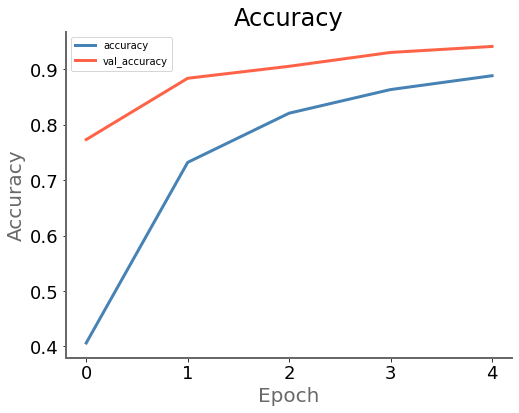

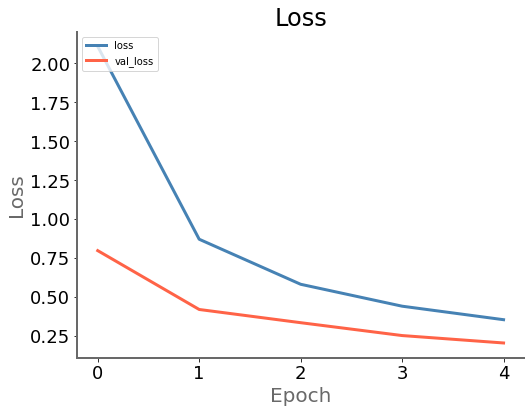

In [13]:
pwk.plot_history(history, save_as='01-history')

## Step 8 - Evaluate best model

### 8.1 - Restore best model :

In [14]:
loaded_model = tf.keras.models.load_model(f'{run_dir}/models/best-model.h5')
# best_model.summary()
print("Loaded.")

Loaded.


### 8.2 - Evaluate it :

In [15]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.2028
Test accuracy  : 0.9413


**Plot confusion matrix**

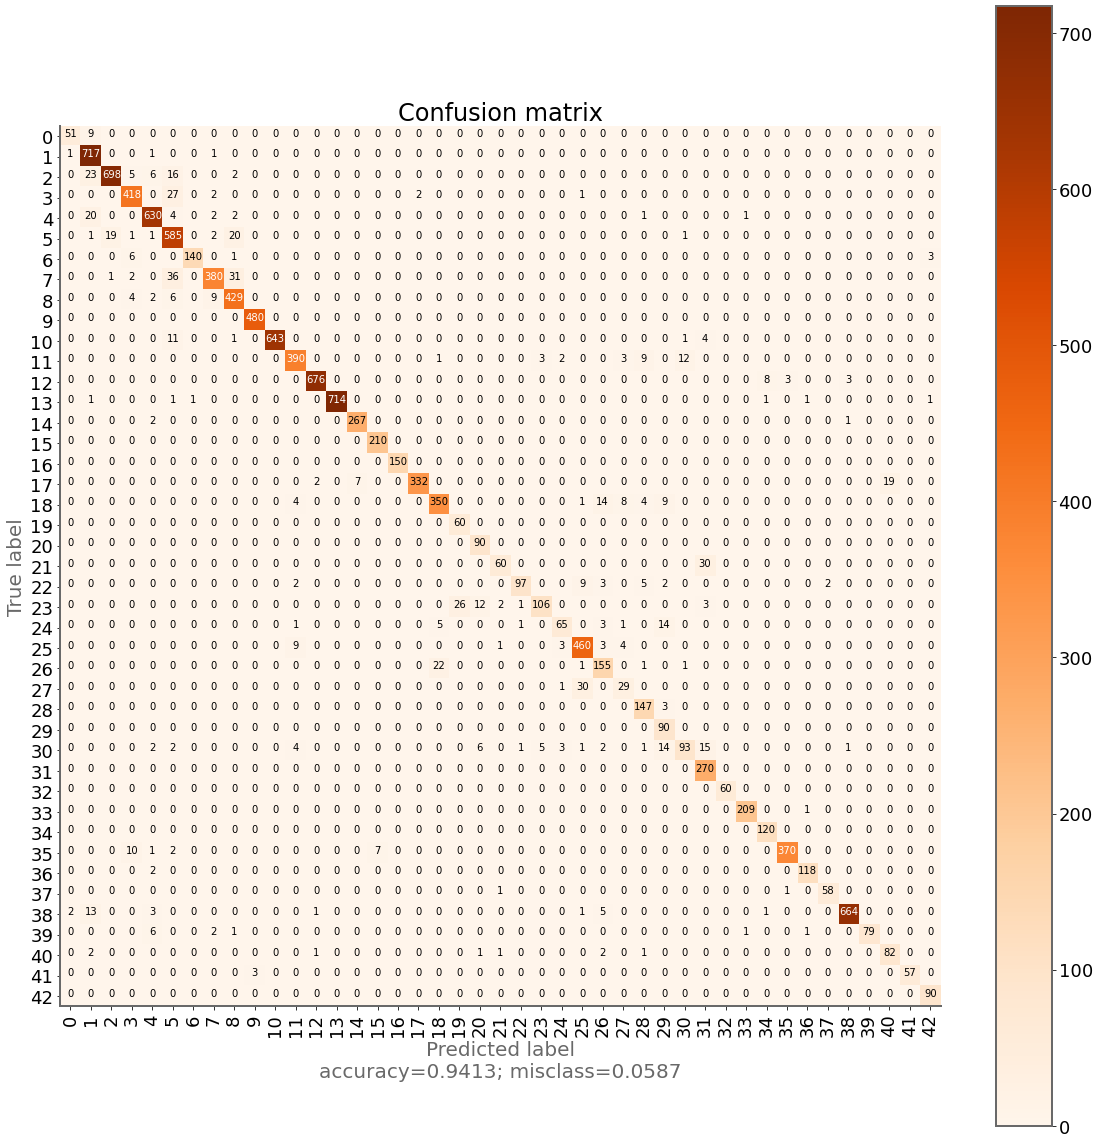

In [16]:
y_sigmoid = model.predict(x_test)
y_pred    = np.argmax(y_sigmoid, axis=-1)

cmap = plt.get_cmap('Oranges')
pwk.plot_confusion_matrix(y_test,y_pred,range(43), figsize=(16, 16),normalize=False, cmap=cmap, save_as='02-confusion-matrix')

In [17]:
pwk.end()

End time is : Monday 01 March 2021, 18:51:29
Duration is : 00:01:29 118ms
This notebook ends here


<div class="todo">
     What you can do:
    <ul>
        <li>Try different datasets / models</li>
        <li>Test different hyperparameters (epochs, batch size, optimization, etc.)</li>
        <li>What's the best strategy?  How to compare?</li>
    </ul>
    
</div>

---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>